<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Проверка-предположения" data-toc-modified-id="Проверка-предположения-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Проверка предположения</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Реализация-алгоритма" data-toc-modified-id="Реализация-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Реализация алгоритма</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#Финальные-комментарии-ревьюера" data-toc-modified-id="Финальные-комментарии-ревьюера-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Финальные комментарии ревьюера</a></span></li></ul></div>

# Защита персональных данных клиентов

**Цель:** защитить данные клиентов страховой компании «Хоть потоп». Необходимо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию и обосновать его корректность. При этом, качество моделей машинного обучения не должно ухудшиться.

**План:**
1. Загрузка и изучение данных
2. Проверка предположения
3. Поиск алгоритма преобразования 
4. Реализация алгоритма

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('10.csv')
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


В предосталвенных данных имеем 5000 строк без пропусков. Типы - integer и float.

In [4]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Описательные статистики дают понять, что в наших данных соотношение полов приближено к 1:1, средний возраст - 31 год, а минимальный - 18 лет, средняя зарплата - 39916 у.е., каждый клиент в среднем имеет 1 члена семьи. 

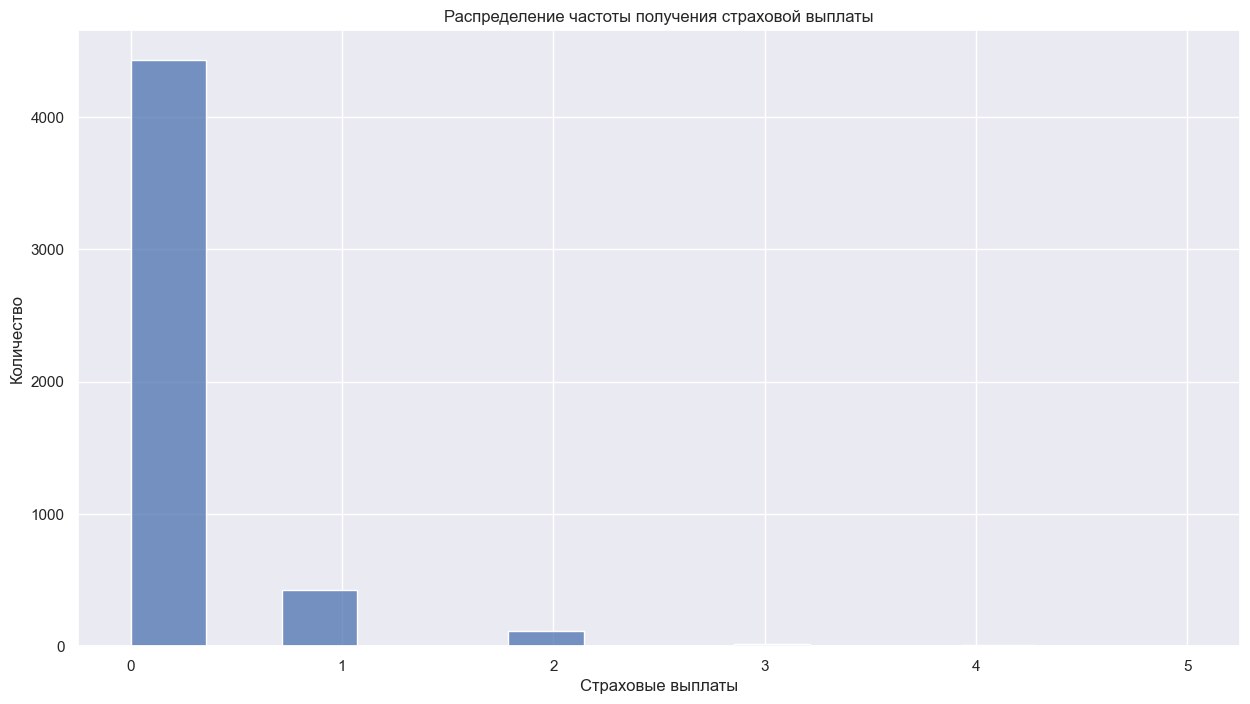

In [6]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.histplot(data['Страховые выплаты']).set(title='Распределение частоты получения страховой выплаты', ylabel='Количество');

Из графика распредления целевого признака видно, подавляющее большинство (около 4500) клиентов не получали страховую выплату, 1 выплату получили примерно 500 человек, остальное количество выплат получило очень мало людей.

Так как будет применяться линейная регрессия, то необходимо проверить данные на **корреляцию**

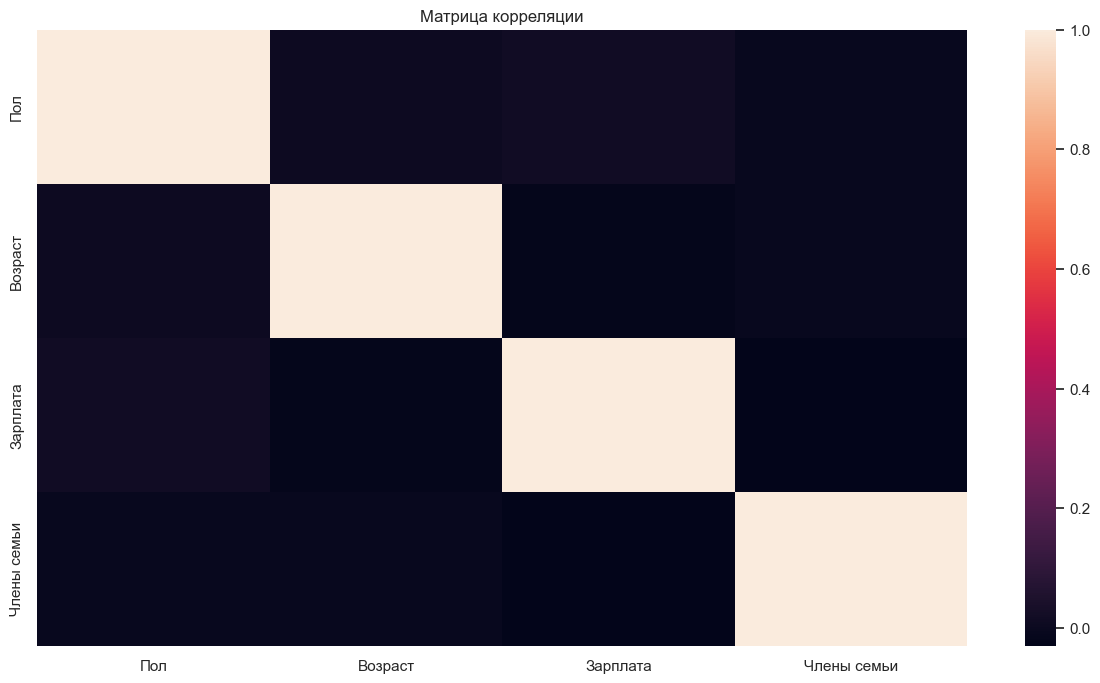

In [7]:
sns.heatmap(data.drop('Страховые выплаты', axis=1).corr()).set(title='Матрица корреляции');

Корелляции между признаками нет, она околонулевая для любой пары.

Последним этапом исследования станет проверка на **дубликаты**

In [8]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 153


Дубликаты есть, но удалять их не будем

**Вывод**

Проведена предобработка, основные закономерности в данных выявлены. Соотношение полов в данных 1:1, средний возраст клиента - 31 год. Исследовано распредление целевого признака. Корреляций между признаками нет

## Проверка предположения

**Вопрос:** признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** домножение на обратимую матрицу не влияет на результат работы линейной регрессии


**Обоснование:** Если мы домножим матрицу признаков на обратимую матрицу P, то формула обучения примет вид:

$$
w' = ((XP)^TXP)^{-1} (XP)^T y
$$

Теперь упростим полученное выражение, учитывая что

$$
(XP)^T = P^TX^T 
$$

Получим:

$$
w' = (P^TX^TXP)^{-1} P^TX^T y
$$

С учётом того, что 

$$
(P^TX^TXP)^{-1} = P^{-1}(X^TX)^{-1}(P^T)^{-1}
$$

Получим:

$$
w' = P^{-1}(X^TX)^{-1}(P^T)^{-1} P^TX^T y
$$

Так как 

$$(P^T)^{-1}P^T = E
$$

Получим:

$$
w' = P^{-1}(X^TX)^{-1}X^T y
$$

Теперь посчитаем предсказания:

$$
a' = XPw' = XPP^{-1}(X^TX)^{-1}X^T y = X(X^TX)^{-1}X^T y = a
$$

В общем виде доказано, что домножение матрицы признаков на обратимую матрицу никоим образом не должно повлиять на предсказания

## Алгоритм преобразования

**Алгоритм**

В прошлом пункте было доказано, что умножение матрицы признаков на обратимую матрицу не влияет на результат работы линейной регрессии. Предлагаю следующий вариант шифрования: 
1. Случайным образом формируется ключевая обратимая матрица. 
2. Ключевая матрица проверяется на обратимость при помощи библиотеки numpy, точнее функции inv()
3. Матрица признаков умножается на ключевую матрицу, что обеспечивает преобразование данных. 

Дополнительные пункты:

4. Обучение линейной регрессии на исходных и на зашифрованных данных
5. Сравнение метрик R2 в первом и во втором случае

Обратим внимание, что данное преобразование обратимо. Обладателю ключевой матрицы будет достаточно умножить данные на обратную ключевой матрицу. А вот без знания ключевой матрицы восстановить данные будет практически невозможно, так как перебор нецелесообразен.

## Реализация алгоритма

Для начала проверим качество регрессии на непреобразованных данных.

In [9]:
model = LinearRegression()
model.fit(data.drop('Страховые выплаты', axis=1), data['Страховые выплаты'])
predictions = model.predict(data.drop('Страховые выплаты', axis=1))
print('Значение метрики R2 составляет', r2_score(data['Страховые выплаты'], predictions))

Значение метрики R2 составляет 0.42494550286668


Теперь преобразуем данные и проверим работу модели, показания должны не измениться.

In [10]:
def encryption(data):
    data = data.values
    key = np.random.randint(30, 200, (len(data[0]), 4))
    try:
        np.linalg.inv(key)
    except:
        print('Ключевая матрица необратима')
        return data, key
    data = data @ key
    return data, key

def decryption(data, key):
    return data @ np.linalg.inv(key)

In [11]:
features, key = encryption(data.drop('Страховые выплаты', axis=1))
model = LinearRegression()
model.fit(features, data['Страховые выплаты'])
predictions = model.predict(features)
print('Значение метрики R2 составляет', r2_score(data['Страховые выплаты'], predictions))

Значение метрики R2 составляет 0.42494550286666544


Можно заметить, что в обоих случаях значение метрики совпадает

## Вывод

**Вывод**

В ходе данного проекта был проведен исследовательский анализ данных страховой компании, затем была доказана гипотеза о том, что умножение матрицы признаков на обратимую матрицу не меняет результат работы линейной регрессии. На основе этого предположения был сформирован алгоритм шифрования данных пользователей, который шифруя данные не влияет на результат работы линейной регрессии. Экспериментально было подтверждено, что результат работы алгоритма машинного обучения не меняется до и после шифрования.